Hariharan Kalimuthu
2020115015
Assignment 1

In [109]:
from nilearn import datasets
import numpy as np
from nilearn.decoding import Decoder
from nilearn.image import index_img
from nilearn.maskers import NiftiMasker
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore") 


haxby_dataset = datasets.fetch_haxby()
func_filename = haxby_dataset.func[0]     



In [110]:
# Load labels
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
stimuli = labels['labels']

# Identify resting state labels in order to be able to remove them
task_mask = (stimuli != 'rest')

# Find names of remaining active labels
categories = stimuli[task_mask].unique()

# Extract tags indicating to which acquisition run a tag belongs
session_labels = labels["chunks"][task_mask]

# Apply the task_mask to  fMRI data (func_filename)
task_data = index_img(func_filename, task_mask)

# Make a data splitting object for cross validation
cv = LeaveOneGroupOut()

In [111]:
# Load Haxby dataset
haxby_dataset = datasets.fetch_haxby()
func_filename = haxby_dataset.func[0]

# Load labels
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
stimuli = labels['labels']

# Identify resting state labels in order to be able to remove them
task_mask = (stimuli != 'rest')

# Find names of remaining active labels
categories = stimuli[task_mask].unique()

# Extract tags indicating to which acquisition run a tag belongs
session_labels = labels["chunks"][task_mask]

# Apply the task_mask to  fMRI data (func_filename)
task_data = index_img(func_filename, task_mask)

# Make a data splitting object for cross validation
cv = LeaveOneGroupOut()

mask_names = ['mask_vt', 'mask_face', 'mask_house']

mask_scores = {}
mask_chance_scores = {}

for mask_name in mask_names:
    mask_filename = haxby_dataset[mask_name][0]
    masker = NiftiMasker(mask_img=mask_filename, standardize=True)
    mask_scores[mask_name] = {}
   
    for category in categories:
        classification_target = (stimuli[task_mask] == category)
        decoder = Decoder(estimator='svc_l1', cv=cv,
                          mask=masker, scoring='roc_auc')
        decoder.fit(task_data, classification_target, groups=session_labels)
        mask_scores[mask_name][category] = decoder.cv_scores_[1]
        
        
    

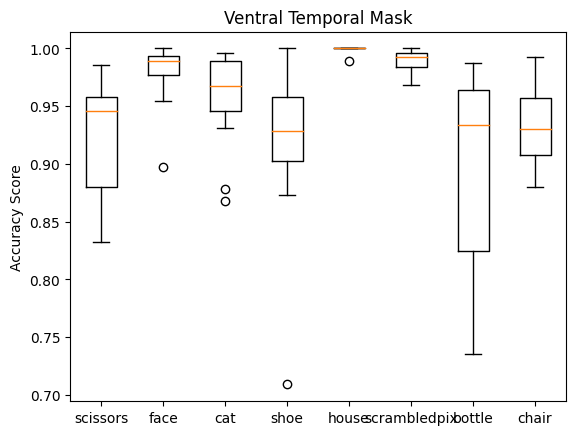

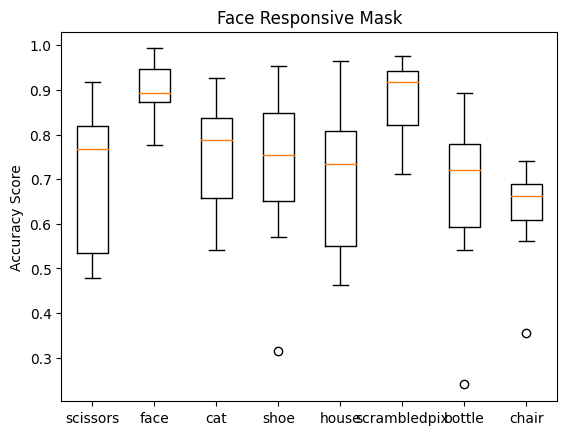

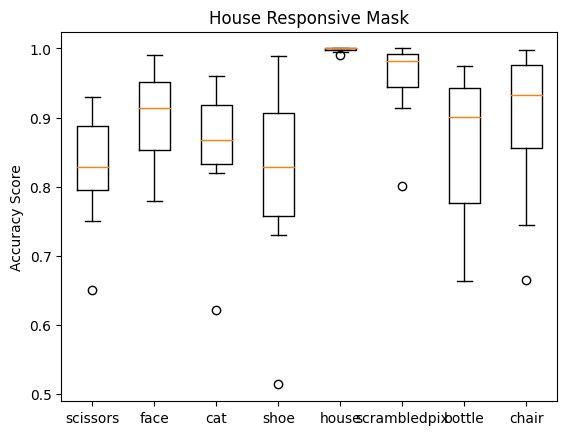

In [112]:
graph_titles=['Ventral Temporal Mask', 'Face Responsive Mask', 'House Responsive Mask']
i=0
for mask_name in mask_names:
    fig, ax = plt.subplots()
    ax.boxplot([mask_scores[mask_name][cat] for cat in categories], labels=categories)
    ax.set_title("%s" % graph_titles[i])
    i=i+1
    ax.set_ylabel("Accuracy Score")
    plt.show()

The above code defines a classifier (Support Vector Machine with L1 penalty) and a cross-validation scheme (LeaveOneGroupOut) and fits the classifier to the preprocessed data. This process was done for three different ROIs, identified by their binary masks: 'mask_vt', 'mask_face', and 'mask_house'. The accuracy scores for each category and each ROI are stored in the dictionary called 'mask_scores'. The box plot depicts the accuracy score vs category of simulation for each ROI.

In [113]:
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=' ')

conditions = behavioral['labels']
sessions = behavioral['chunks']

unique_sessions = sessions.unique()

In [114]:

TR=2.5
events ={}
for session in sessions:
    conditions_session = conditions[sessions == session]

    n_scans = len(conditions_session)
    frame_times = TR * np.arange(n_scans)

    duration = TR * np.ones(n_scans)

    events[session] = pd.DataFrame(
        {'onset': frame_times,
        'trial_type': conditions_session,
        'duration': duration})

assert len(events) == 12

for i in events:
    assert events[i].shape == (121, 3)


In [115]:
from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import index_img
from nilearn import image
fmri_img = image.load_img(haxby_dataset['func'])
from numpy import array

contrasts = {
    'bottle': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'cat':   array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'chair':   array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'face':   array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'house':   array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'rest':   array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'scissors':   array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
    'scrambledpix':   array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
    'shoe':   array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
}

z_maps = []
conditions_label = []
each_session_label = []

for session in unique_sessions:
    glm = FirstLevelModel(t_r=TR,
                            mask_img=haxby_dataset.mask,
                            high_pass=0.008,
                            smoothing_fwhm=8.)  

    fmri_session = index_img(fmri_img, sessions == session)
    glm.fit(fmri_session, events=events[session])
    for condition in categories:
        condition_minus_rest = contrasts[condition] - contrasts['rest']
        z_map_condition_vs_rest = glm.compute_contrast(condition_minus_rest,
                                         output_type='z_score')
        z_maps.append(z_map_condition_vs_rest)
        conditions_label.append(condition)
        each_session_label.append(session)

        


In [116]:
assert len(z_maps) == 96
assert len(conditions_label) == 96
assert len(each_session_label) == 96

In [119]:
mask_scores_face_house = {}

# z_maps = []
# conditions_label = []
# each_session_label = []

mask_scores = {}


for mask_name in mask_names:
    mask_filename = haxby_dataset[mask_name][0]
    # mask_filename = z_maps
    masker = NiftiMasker(mask_img=mask_filename, standardize=True)
    mask_scores_face_house[mask_name] = {}


    for category in categories:
        classification_target = conditions_label
        decoder = Decoder(estimator='svc_l1', cv=cv,
                          mask=masker, scoring='roc_auc')
        decoder.fit(z_maps, classification_target, groups=each_session_label)
        mask_scores_face_house[mask_name][category] = decoder.cv_scores_[category]


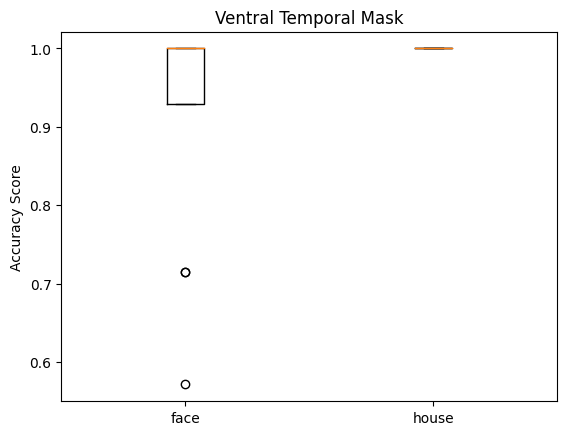

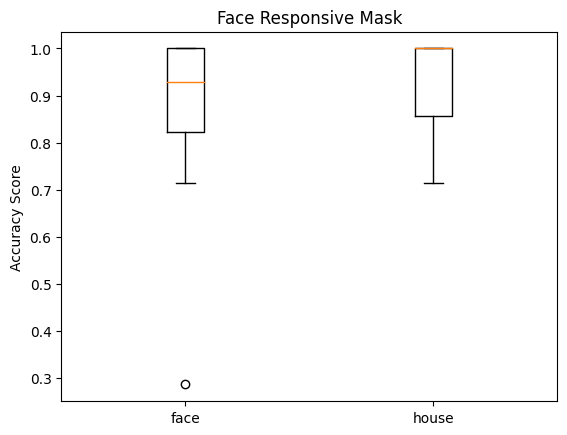

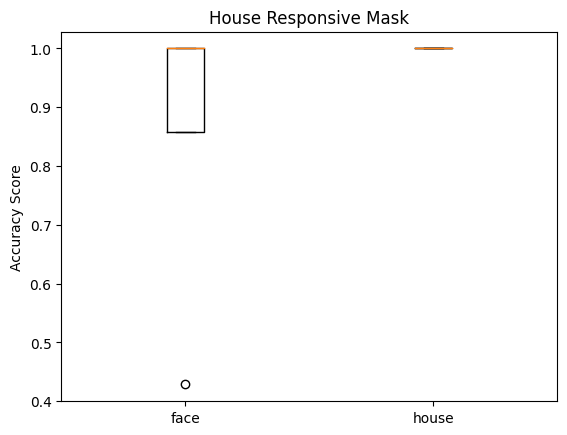

In [120]:
graph_titles=['Ventral Temporal Mask', 'Face Responsive Mask', 'House Responsive Mask']
i=0
for mask_name in mask_names:
    fig, ax = plt.subplots()
    ar =  ['face', 'house']
    ax.boxplot([mask_scores_face_house[mask_name][cat] for cat in ar], labels=ar)
    ax.set_title("%s" % graph_titles[i])
    i=i+1
    ax.set_ylabel("Accuracy Score")
    plt.show()

Q1) Both these types of inputs (statistically derived maps as well as raw time series data) can be used to build classification models and provide us with a lot of information. The natuer of the study and experimentation decides what would be a more appropriate dataset to be used. Raw timeseries data can also be noisy and may contain a lot of irrelevant information, making it difficult to identify specific patterns of activity related to the experimental stimuli. Hence, in this study, Statistically derived maps, have technically helped us summarize the data by aggregating across voxels or regions and summarizing the information and has been useful for identifying regions or voxels that are consistently activated or deactivated in response to specific stimuli, making it easier to identify patterns of activity related to the experimental stimuli. Also quoting from an article "Multivariate pattern analysis (MVPA) of fMRI data has proven to be more sensitive and more informative about the functional organization of cortex than is univariate analysis with the general linear model (GLM)" (Haxby JV. Multivariate pattern analysis of fMRI: the early beginnings. Neuroimage. 2012 Aug 15;62(2):852-5. doi: 10.1016/j.neuroimage.2012.03.016. Epub 2012 Mar 9. PMID: 22425670; PMCID: PMC3389290). Hence, we can see that the study has proved that applying statistical analysis (i.e. using activation maps) to predict the experimental stimuli has proved to be a better method in this context since it provides us with more reliable information than using raw timeseries signal data. 

Q2) The classification model built using beta maps seem to be more aligned to the conclusions of the original paper. 
